In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
import sklearn.model_selection as ms
import scipy.stats as stats
import scipy
print (scipy.__version__)

1.8.0


# **Dataset Amazon Top 50 Bestselling Books 2009 - 2022**


Il dataset contiene i 50 libri best seller per anno dal 2009 al 2022

In questo notebook studieremo le preferenze degli utenti e gli effetti che la pandemia ha avuto sulla vendita di libri su amazon, utilizzando quindi i bestseller

Il notebook è strutturato in tre punti principali:
+ numero di reviews prima e dopo il 2020
+ il genere preferito dall'utenza
+ la variazione del prezzo 
+ studio del titolo

Per prima cosa facciamo qualche operazione preliminare per conoscere meglio il dataset:

In [2]:
book = pd.read_csv('bestsellers.csv') 
book.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


Da una lettura preliminare del dataset attraverso la funzione head possiamo già capire che si potrà lavorare ad esempio sul campo "genre" che assume solo due tipi (fiction e non fiction) e capirne la correlazione con gli anni, le valutazioni ecc. ecc.

##### Ragioniamo adesso sul significato di ogni colonna e sul loro livello

- *Name*: il nome del libro (qualitativo)
- *Author*: l'autore del libro (qualitativo)
- *User Rating*: il punteggio di ogni libro
- *Reviews*: il numero di recensioni di quel determinato libro
- *Price*: prezzo del libro
- *Year*: anno di pubblicazione del libro
- *Genre*: genere del libro (valore "booleano")

Estraiamo informazioni di base sul nostro dataset.

In [3]:
book.describe()

,User Rating,Reviews,Price,Year
count,700.000000,700.000000,700.000000,700.000000
mean,4.639857,19255.195714,12.700000,2015.500000
std,0.218586,23613.443875,9.915162,4.034011
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4987.250000,7.000000,2012.000000
50%,4.700000,10284.000000,11.000000,2015.500000
75%,4.800000,23358.000000,15.000000,2019.000000
max,4.900000,208917.000000,105.000000,2022.000000


Controllo se ci sono colonne con elementi vuoti, come vedremo non ci sono e quindi non dovrò eseguire funzioni di riempimento automatico

In [4]:
book.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

quanti dati e quante caratteristiche abbiamo a disposizione?

In [5]:
book.shape

(700, 7)

Dall'output della funzione shape capiamo che le colonne sono 7 (informazione già conosciuta) e che il numero di righe e cioè libri nel dataset è 700

Tutte le caratteristiche sono abbastanza significative tolte quelle qualitative come il nome e l'autore (che però non sono completamente inutili) e quindi non credo sia necessario eliminare delle colonne

Adesso controlliamo che non ci siano elementi duplicati nel nostro dataset:

In [6]:
book['Name'].describe()

count                                                   700
unique                                                  441
top       Publication Manual of the American Psychologic...
freq                                                     10
Name: Name, dtype: object

Come possiamo vedere sono presenti numerosi libri duplicati nel nostro dataset, forse per il fatto che un libro è stato bestseller per più anni o forse perchè il dataset è stato riempito automaticamente

Dei nostri 700 elementi solo 441 sono seriamente significativi

In [7]:
duplicate_book = book['Name'].describe()['top']
book_is_duplicate = book['Name'] == duplicate_book
book_is_duplicate.head()

0    False
1    False
2    False
3    False
4    False
Name: Name, dtype: bool

In [8]:
sum(book_is_duplicate)

10

In [9]:
filtered_dataframe = book[book_is_duplicate]
filtered_dataframe

,Name,Author,User Rating,Reviews,Price,Year,Genre
22,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2009,Non Fiction
70,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2010,Non Fiction
120,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2011,Non Fiction
170,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2012,Non Fiction
225,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2013,Non Fiction
276,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2014,Non Fiction
329,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2015,Non Fiction
379,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2016,Non Fiction
425,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2017,Non Fiction
479,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2018,Non Fiction


Ad esempio questo libro della American Psycological Association è presente ben 10 volte nel dataset

Decido quindi di eliminare i duplicati

In [10]:
book.drop_duplicates(['Name','Author'],
                     keep = False, inplace = True)

In [11]:
book['Name'].describe()

count                                                   319
unique                                                  319
top       Act Like a Lady, Think Like a Man: What Men Re...
freq                                                      1
Name: Name, dtype: object

Adesso calcoliamo la correlazione

In [12]:
book.corr(method='pearson')

,User Rating,Reviews,Price,Year
User Rating,1.000000,0.035590,0.012089,0.249597
Reviews,0.035590,1.000000,-0.034825,0.471143
Price,0.012089,-0.034825,1.000000,-0.096436
Year,0.249597,0.471143,-0.096436,1.000000


La correlazione tra dati che si nota maggiormente è quella Reviewes - Year e quella User Rating - Year.

In [13]:
#sb.pairplot(book)

## REVIEWS NEGLI ANNI

Applicando un semplice grafico lineare si può vedere come proprio tra il 2019 e il 2020 c'è stato un vertiginoso inalzamento delle reviews

In [14]:
annual_reviews = book.groupby('Year')[['Reviews']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_reviews)

    Year       Reviews
0   2009   3731.657895
1   2010   3078.620690
2   2011   4776.631579
3   2012   9121.368421
4   2013   7985.380952
5   2014   9337.894737
6   2015   8033.000000
7   2016   8456.952381
8   2017   8967.421053
9   2018   8337.285714
10  2019   8473.619048
11  2020  42729.000000
12  2021  30634.500000
13  2022  16453.125000


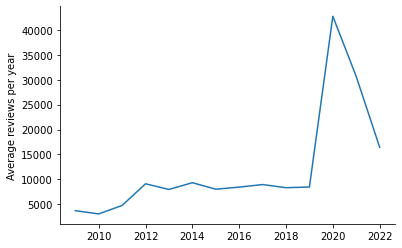

In [15]:
fig, ax = plt.subplots()
plt.plot(annual_reviews['Year'], annual_reviews['Reviews'])
plt.ylabel('Average reviews per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Reviews'>

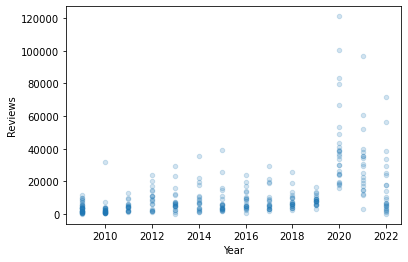

In [16]:
book.plot(kind= 'scatter', x= 'Year', y= 'Reviews', alpha= 0.2)

Questo è un chiaro esempio di come la pandemia ha effettivamente cambiato le abitudini.

A partire infatti dal 2020 c'è un aumento vertiginoso del numero di reviews, che può anche essere legato al numero di copie comprate (dato non presente purtroppo nel dataset)

Come possiamo vedere nel 2019 il numero medio di reviews si aggira attorno alle 8000 mentre nel 2020 il numero medio è 42000

Questo aumento è così improvviso e corposo non può essere ignorato, e deve essere sicuramente collegato ad un evento d'impatto come la pandemia.

Come immaginabile infatti, con la fine del lockdown più pesante nel 2020 il numero di reviews si è, pur restando molto alto, ridimensionato

Infine guardiamo se le reviews sono collegate in qualche modo alla valutazione del libro.

<AxesSubplot:title={'center':'Reviews'}, xlabel='User Rating'>

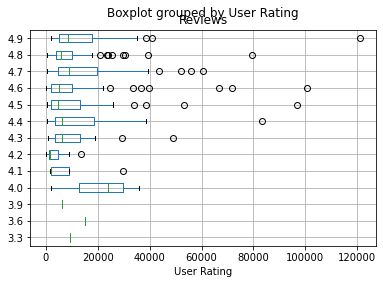

In [17]:
book.boxplot(column='Reviews', by='User Rating', vert = False)

## STUDIO SUL GENERE PREFERITO

Le abitudini dei lettori sono cambiate con la pandemia? Anche se i dati sono un po' vaghi(distinzione solo tra Fiction e Non Fiction) possiamo vedere se le preferenze nei bestseller sono cambiate

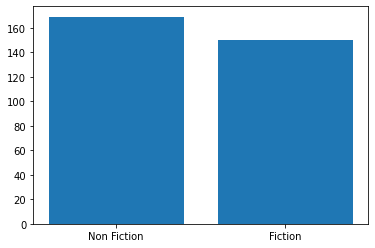

In [18]:
counts = book["Genre"].value_counts()
plt.bar(counts.index,counts.values)
plt.show()

Come possiamo vedere dal grafico c'è una predominanza (anche se leggera) del genere "Non Fiction" rispetto a quello fiction

([<matplotlib.patches.Wedge at 0x7fd77daf5ff0>,
 [Text(-0.10276417843205532, 1.0951892638403578, 'Fiction'),
  Text(0.10276417843205543, -1.0951892638403578, 'Non Fiction')],
 [Text(-0.05605318823566654, 0.5973759620947405, '53.0%'),
  Text(0.056053188235666594, -0.5973759620947405, '47.0%')])

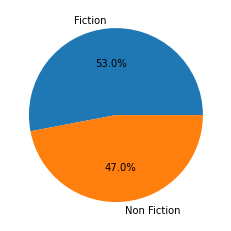

In [19]:
plt.pie(book['Genre'].value_counts(),labels=['Fiction','Non Fiction'],autopct='%.1f%%')

[Text(0.5, 1.0, 'genre distribution')]

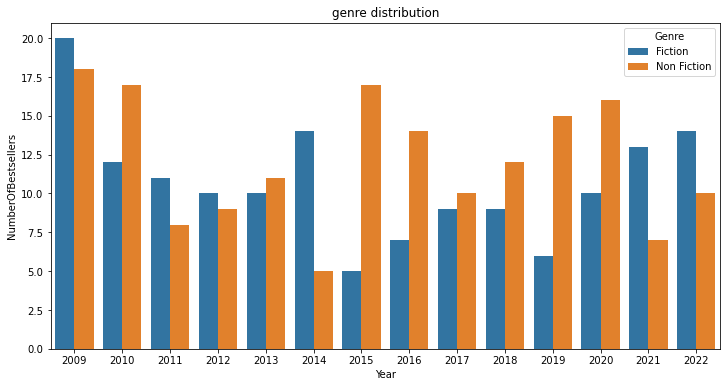

In [20]:
df=book.groupby(['Genre', 'Year']).size().reset_index(name='NumberOfBestsellers')
plt.figure(figsize=(12, 6))
sb.barplot(x='Year', y='NumberOfBestsellers', hue='Genre', data=df).set(title='genre distribution')

Attraverso la libreria seaborn possiamo vedere come c'è una distribuzione abbastanza casuale dei due generi anche se quello "non fiction" predomina quasi sempre

Negli ultimi anni c'è stata una "risalita" del genere "fiction" ma non è per forza collegato alla pandemia visto che anche in altri anni (2014) c'era stata una predominanza dei libri "fiction"

In [21]:
book.groupby('Genre')[['Reviews']].mean().reset_index()

,Genre,Reviews
0,Fiction,15371.766667
1,Non Fiction,9057.656805


Il numero di reviews medio dei libri Fiction è nettamente maggiore e come già detto in precedenza questo potrebbe essere strettamente collegato al numero di copie vendute.
Potrebbero quindi esserci un numero minore di bestseller di tipo fiction ma con più copie vendute 

In [22]:
book.groupby('Genre')[['User Rating']].mean().reset_index()

,Genre,User Rating
0,Fiction,4.620000
1,Non Fiction,4.621893


Senza l'utilizzo di un grafico possiamo vedere lo user rating è pressochè uguale quindi poco significativo

T-test su differenza rating in base al genere
Ipotesi:

+ H0: Non ci sono differenze di valutazioni tra i due generi
+ H1: I due generi hanno valutazioni completamente differenti

Scegliamo un intervallo di confidenza pari a 0.95.

In [23]:
t_statistic, p_value = stats.ttest_1samp(a= book['User Rating'][book['Genre']=="Fiction"], popmean= book['User Rating'][book['Genre']!="Fiction"].mean(),alternative='less')
print(t_statistic)
print(p_value)

-0.08727586614279535
0.4652847093019611


come possiamo vedere il p-value è molto più grande rispetto al livello di significatività e per questo si può affermare che l'ipotesi H0 è confermata

//TODO

## IL PREZZO

Un altro interessante studio che si può fare è quello sul prezzo: è aumentato negli anni? è diminuito? il genere incide sul prezzo del libro?

In [24]:
annual_price = book.groupby('Year')[['Price']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_price)

    Year      Price
0   2009  15.657895
1   2010  12.103448
2   2011  15.210526
3   2012  16.105263
4   2013  13.142857
5   2014  12.684211
6   2015   9.818182
7   2016  16.952381
8   2017  12.368421
9   2018  10.857143
10  2019  10.666667
11  2020  11.038462
12  2021  11.700000
13  2022  15.333333


Non sembra esserci stato un aumento significativo dei prezzi medi con l'avvento del covid

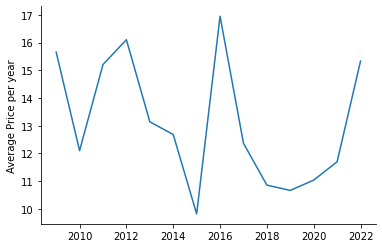

In [25]:
fig, ax = plt.subplots()
plt.plot(annual_price['Year'], annual_price['Price'])
plt.ylabel('Average Price per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Come si nota dal grafico il prezzo è molto variabile

<AxesSubplot:title={'center':'Price'}, xlabel='Year'>

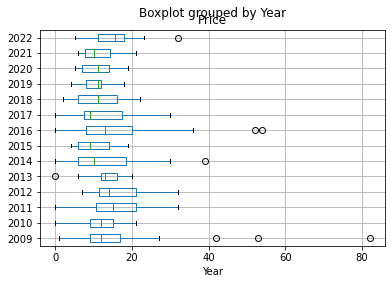

In [26]:
book.boxplot(column='Price', by='Year', vert = False)

Utilizzando anche un grafico boxplot vediamo come il range di prezzo è maggiore dal 2009 al 2014 per poi stabilizzarsi senza avere gap di prezzo troppo elevati

Una volta fatte queste considerazioni preliminari sul prezzo dei bestSeller vediamo se il genere incide sul prezzo:

In [27]:
book.groupby('Genre')[['Price']].mean().reset_index()

,Genre,Price
0,Fiction,12.866667
1,Non Fiction,13.467456


Il prezzo dei libri "Non Fiction" è più alto rispetto a quelli Fiction

<AxesSubplot:xlabel='Year', ylabel='Price'>

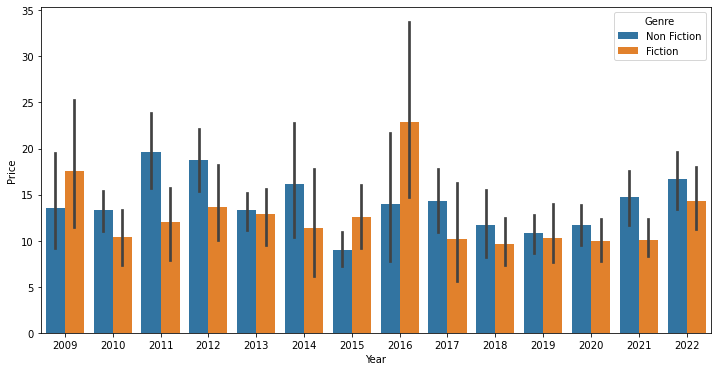

In [28]:
plt.figure(figsize=(12,6))
sb.barplot(data=book, x='Year', y='Price', hue='Genre')

Utilizzando la libreria seaborn che offre grafici molto precisi possiamo vedere come il prezzo dei libri "non fiction" è solitamente più alto rispetto a quello dei libri Fiction in ogni anno

Possiamo confermare quanto appena detto attraverso un T-test:

H0: i libri "Non Fiction" costano di più rispetto a quelli "Fiction"

H1:i libri "Non Fiction" costano di meno rispetto a quelli "Fiction"

In [29]:
t_statistic, p_value = stats.ttest_1samp(a= book['Price'][book['Genre']=="Fiction"], popmean= book['Price'][book['Genre']!="Fiction"].mean(),alternative='less')
print(t_statistic)
print(p_value)

-0.7689541735472527
0.22156884183029363


Usando sempre lo stesso intervallo di confidenza dello 0.95 vediamo come il livello di significatività è più basso del p-value e per questo posso accettare l'ipotesi H0

Dallo studio della correlazione vediamo inoltre come il prezzo non incide su il numero di reviews e user rating

## IL TITOLO

I dati a nostra disposizione non sono molti, per questo dobbiamo cercare di utilizzare ogni informazione a nostra disposizione

Utilizziamo un dato qualitativo come il Nome, che a primo impatto sembrerebbe inutile se non per contrassegnare un elemento del dataset

Possiamo ad esempio vedere se ci sono parole nei titoli più amati che rendono un libro "vincente" portando il pubblico di amazon a comprarne una copia rispetto ad altri libri

Prendiamo quindi ad esempio tutti i libri con una valutazione molto alta

Per prima cosa andiamo a studiare il rating dei libri:

(4.58, 4.74]     0.373041
(4.74, 4.9]      0.326019
(4.26, 4.42]     0.122257
(4.42, 4.58]     0.119122
(4.1, 4.26]      0.028213
(3.94, 4.1]      0.021944
(3.297, 3.46]    0.003135
(3.46, 3.62]     0.003135
(3.78, 3.94]     0.003135
(3.62, 3.78]     0.000000
Name: User Rating, dtype: float64


<AxesSubplot:>

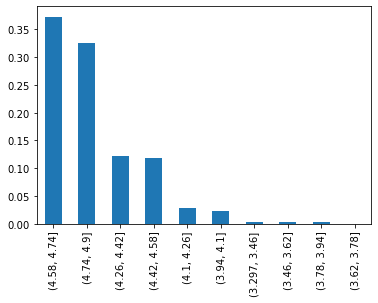

In [30]:
rating = book['User Rating']
rating = rating.value_counts(bins=10,normalize=True)
print(rating)
rating.plot(kind = 'bar')

Come possiamo vedere dal grafico i bestseller con un maggiore User Rating hanno dei valori tra il 4.58 e il 4.9 (prime due colonne), possiamo utilizzare quelli come campione visto che sono anche la maggior parte dei dati

Creiamo quindi un dataset per capire se la valutazione è più alta o più bassa in base al titolo del libro

In [31]:
book_best_worst = book[(book['User Rating'] > 4.58) | (book['User Rating'] < 4.58)]
# creiamo adesso un dataset per il problema di classificazione binaria in cui vogliamo provare a 
# capire se una persona ha assegnato 1 o 5 stelle sulla base della recensione

In [32]:
X = book_best_worst.Name
y = book_best_worst['User Rating'] > 4.58

print(X.shape)
print(y.shape)

(319,)
(319,)


A questo punto conto le parole nel titoli, togliendo quelle più comuni nel parlato inglese come the,a,an ecc ecc

In [33]:
vect = CountVectorizer(stop_words='english')
X_dtm = vect.fit_transform(X)
print(X_dtm.shape)

(319, 1005)


estraiamo a caso i dati per organizzarli in un insieme di training e validazione

In [34]:
X_train, X_test, y_train, y_test = ms.train_test_split(X_dtm, y, random_state=100)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(239, 1005)
(239,)
(80, 1005)
(80,)


Applichiamo la regressione logistica e alleniamo il modello sui nostri dati

In [35]:
lr = LogisticRegression()
Model = lr.fit(X_train, y_train)

In [36]:
lr.score(X_test, y_test)

0.725

A questo punto possiamo applicare l'analisi delle componenti principali PCA per le prime 100 componenti principali

Usiamo tutti i nostri dati ma dentro una matrice densa (.todense())

In [37]:
vect = CountVectorizer(stop_words='english')
X_dtm = vect.fit_transform(X).todense()
print(X_dtm.shape)

(319, 1005)


istanziamo un oggetto PCA a cui chiediamo di identificate le prime 100 componenti principali e calcoliamo la decomposizione

In [38]:
pca = decomposition.PCA(n_components=100)

In [39]:
X_pca = pca.fit_transform(X_dtm)
print(X_pca.shape)

(319, 100)


/home/nenne/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [40]:
X_train, X_test, y_train, y_test = ms.train_test_split(X_pca, y, random_state=100)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(239, 100)
(239,)
(80, 100)
(80,)


A questo punto alleniamo nuovamente il modello con i nostri nuovi dati ricevuti

In [41]:
Model = lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.6375

//TODO
Non ho capito bene cos'è

In [42]:
def explainedVariance(eig_vals):
    
    eigvals = eig_vals
    if(len(eig_vals)>1000):
        eigvals = eig_vals[1:1000]
    print(eigvals.shape)
    tot = sum(eigvals)
    var_exp = [(i / tot)*100 for i in eigvals]
    cum_var_exp = np.cumsum(var_exp)
    
    return cum_var_exp

(1005, 1005)
(999,)


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Cumulative explained variance')

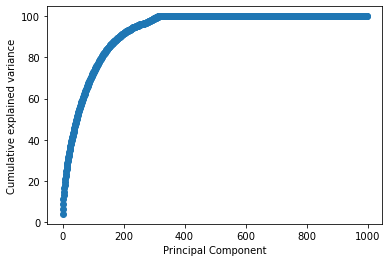

In [43]:
mean = X_dtm.mean(axis=0)
X_z = X_dtm - mean

C = X_z.T.dot(X_z)
    
print(C.shape)
# compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvec = np.linalg.eig(C)

expl_var = explainedVariance(eigvals)

plt.plot(expl_var, '-o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')

## CLUSTERING

//TODO

## STUDIO DEGLI AUTORI

Ci sono autori che hanno venduto più di altri? che genere preferiscono?

<Figure size 1296x1296 with 0 Axes>

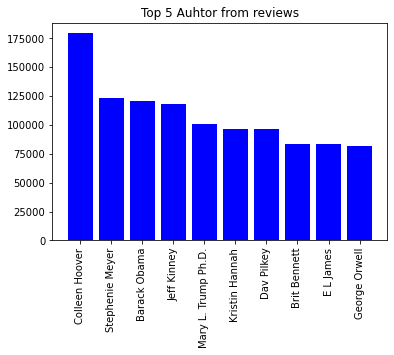

<Figure size 1296x1296 with 0 Axes>

In [44]:
x=book.groupby('Author')['Reviews'].agg([sum]).sort_values(by=('sum'),ascending=False).head(10)
q3=pd.DataFrame(x)
q3.reset_index(inplace=True)
plt.bar(q3['Author'],q3['sum'],color="blue")
plt.title("Top 5 Auhtor from reviews")
plt.xticks(rotation=90)
plt.figure(figsize=(18,18))

L'autrice con più recensioni e quindi probabilmente copie vendute è Collen Hoover, vediamo quanti libri ha scritto (4)

In [45]:
Hoover = np.where(book['Author']=="Colleen Hoover")[0]
print(np.shape(Hoover))

(4,)


In [46]:
print(Hoover)

[304 308 317 318]


CONTINUARE

## CONCLUSIONI

Dallo studio del dataset si è concluso come:
+ Il numero di reviews negli anni è salito vertiginosamente
+ in generale c'è una preferenza verso i libri Non Fiction
+ il prezzo medio dei bestseller è variato molto negli anni
+ in generale i libri Fiction hanno un prezzo superiore di alcuni euro